# Реализация модели сегментации клиентов онлайн магазина с помощью технологий глубокого обучения

E-Commerce Data
https://www.kaggle.com/datasets/carrie1/ecommerce-data
Этот транснациональный набор данных включает в себя все транзакции, произошедшие с 01/12/2010 по 09/12/2011 года в онлайн-розничной компании, зарегистрированной в Великобритании и не имеющей физических магазинов. Компания в основном продает уникальные подарки на любой случай. Многие клиенты компании являются оптовиками.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [ ]:
# Игнорирование ненужных сообщений об ошибках
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [ ]:
# sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

## Обзор датасета

В начале предварительный анализ, чтобы понять структуру и типы столбцов данных

In [ ]:
df = pd.read_csv('data.csv', encoding="ISO-8859-1")

In [ ]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Числовые признаки

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


Категориальные признаки

In [ ]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


Набор данных состоит из 541909 записей и 8 столбцов.
- InvoiceNo столбец, который содержит номер счета для каждой транзакции
- StockCode столбец, представляющий код продукта для каждого товара
- Description содержит описания продуктов
- Quantity целочисленный столбец, указывающий количество продуктов, приобретенных в каждой транзакции
- InvoiceDate столбец, в котором записываются дата и время каждой транзакции
- UnitPrice столбец, представляющий цену за единицу каждого продукта
- CustomerID столбец, содержащий идентификатор клиента для каждой транзакции
- Country столбец, в котором указывается страна, в которой произошла каждая транзакция

Следующие шаги будут включать более глубокую очистку и предварительную обработку данных для обработки пропущенных значений, потенциально ошибочных данных и создания новых функций, которые могут помочь в достижении целей проекта.

# Очистка данных и преобразование

Этот шаг включает в себя комплексный процесс очистки и преобразования для уточнения набора данных. Он включает в себя устранение пропущенных значений, устранение повторяющихся записей, исправление аномалий в кодах и описаниях продуктов, а также другие необходимые корректировки для подготовки данных для углубленного анализа и моделирования

## Пропущенные значения

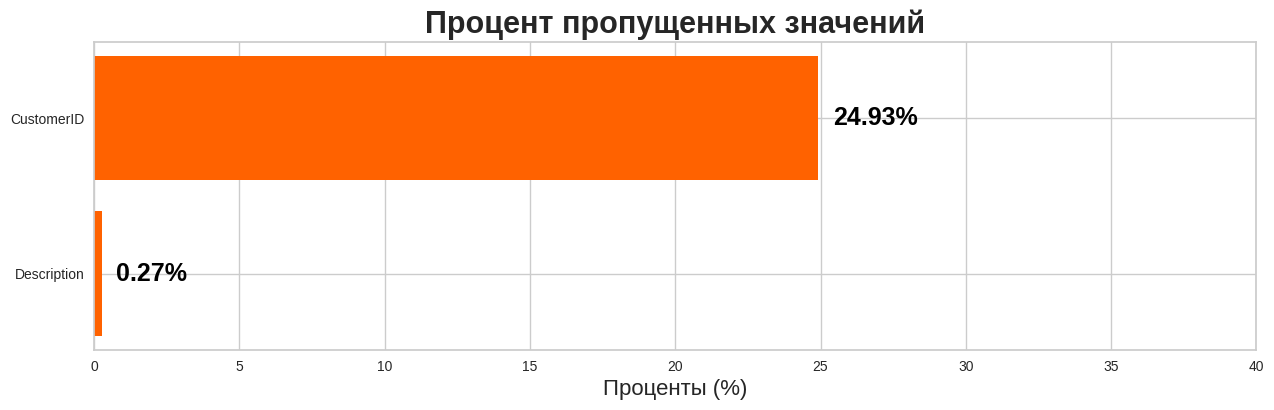

In [ ]:
# Вычисление процента пропущенных значений для каждого столбца
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

missing_percentage.sort_values(ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

ax.set_xlim([0, 40])
plt.title("Процент пропущенных значений", fontweight='bold', fontsize=22)
plt.xlabel('Проценты (%)', fontsize=16)
plt.show()

- CustomerID (24,93% пропущенных значений) Столбец содержит почти четверть недостающих данных. Этот столбец необходим для кластеризации клиентов и создания системы рекомендаций. Использование такого большого процента пропущенных значений может внести в анализ значительную погрешность или шум. Более того, поскольку кластеризация основана на поведении и предпочтениях клиентов, крайне важно иметь точные данные об идентификаторах клиентов. Поэтому удаление строк с отсутствующими идентификаторами CustomerID кажется наиболее разумным подходом для сохранения целостности кластеров и анализа.
- Descripion (0,27 % отсутствующих значений) Столбец содержит небольшой процент пропущенных значений. Однако было замечено, что в данных имеются несоответствия, когда один и тот же StockCode не всегда имеет одинаковое описание. Это указывает на проблемы с качеством данных и потенциальные ошибки в описаниях продуктов. Учитывая эти несоответствия, вменение недостающих описаний на основе StockCode может быть ненадежным. Более того, поскольку процент пропущенных данных довольно низок, было бы разумно удалить строки с отсутствующими описаниями, чтобы избежать распространения ошибок и несоответствий в последующие анализы.

In [ ]:
# Извлечение строк с отсутствующими значениями в столбцах 'CustomerID' или 'Description'
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [ ]:
# Удаление строк с отсутствующими значениями в столбцах 'CustomerID' и 'Description'
df = df.dropna(subset=['CustomerID', 'Description'])

In [ ]:
# Проверка удаления пропущенных значений
df.isnull().sum().sum()

0

In [ ]:
df.shape

(406829, 8)

## Поиск дубликатов

In [ ]:
# Поиск повторяющихся строк (сохранение всех экземпляров)
duplicate_rows = df[df.duplicated(keep=False)]

# Сортировка данных по определенным столбцам, чтобы увидеть повторяющиеся строки рядом друг с другом
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


В контексте этого проекта наличие полностью идентичных строк, включая одинаковое время транзакций, предполагает, что это могут быть ошибки записи данных, а не настоящие повторяющиеся транзакции. Сохранение этих повторяющихся строк может привести к появлению шума и потенциальных неточностей в системе кластеризации и рекомендаций. Поэтому лучше удалить эти полностью идентичные повторяющиеся строки из набора данных. Удаление этих строк поможет получить более чистый набор данных, что, в свою очередь, поможет создать более точные кластеры клиентов на основе их уникального покупательского поведения. Более того, это поможет создать более точную систему рекомендаций за счет правильного определения продуктов с наибольшим количеством покупок.

In [ ]:
print(f"Дата содержит {df.duplicated().sum()} дубликатов")
df.drop_duplicates(inplace=True)

Дата содержит 5225 дубликатов


In [ ]:
df.shape[0]

401604

## Обработка отмененных транзакций

Чтобы уточнить наше понимание поведения и предпочтений клиентов, нам необходимо принять во внимание отмененные транзакции. Первоначально мы определим эти транзакции, отфильтровав строки, в которых номер начинается с «C». Впоследствии мы проанализируем эти строки, чтобы понять их общие характеристики или закономерности

In [ ]:
# Отфильтруйте строки с InvoiceNo, начинающиеся с "C", и создайте новый столбец, указывающий статус транзакции
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


Все значения в отмененных транзакциях отрицательны, что указывает на то, что это действительно отмененные заказы. Столбец UnitPrice имеет значительный разброс, показывая, что в отмененных транзакциях участвовали различные продукты, от низкой до высокой стоимости.

Учитывая цель проекта — кластеризовать клиентов на основе их покупательского поведения и предпочтений и в конечном итоге создать систему рекомендаций, крайне важно понять модели отказа клиентов. Поэтому стратегия состоит в том, чтобы сохранить эти отмененные транзакции в наборе данных, четко помечая их для облегчения дальнейшего анализа. Этот подход позволит улучшить процесс кластеризации, включив закономерности и тенденции, наблюдаемые в данных об отмене, которые могут отражать определенное поведение или предпочтения клиентов. Разрешить системе рекомендаций предотвращать предложение продуктов, которые с высокой вероятностью будут отменены, тем самым улучшая качество рекомендаций.

In [ ]:
# Определение процента отмененных транзакций
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100
print(f"Процент отмененных транзакций {cancelled_percentage:.2f}%")

Процент отмененных транзакций 2.21%


## Исправление аномалий StockCode

Прежде всего, найдем количество уникальных кодов акций и построим график 10 самых частых кодов акций вместе с их процентной частотой

In [ ]:
# Поиск количества уникальных биржевых кодов
unique_stock_codes = df['StockCode'].nunique()
print(f"Число уникальных типов в датасете {unique_stock_codes}")

Число уникальных типов в датасете 3684


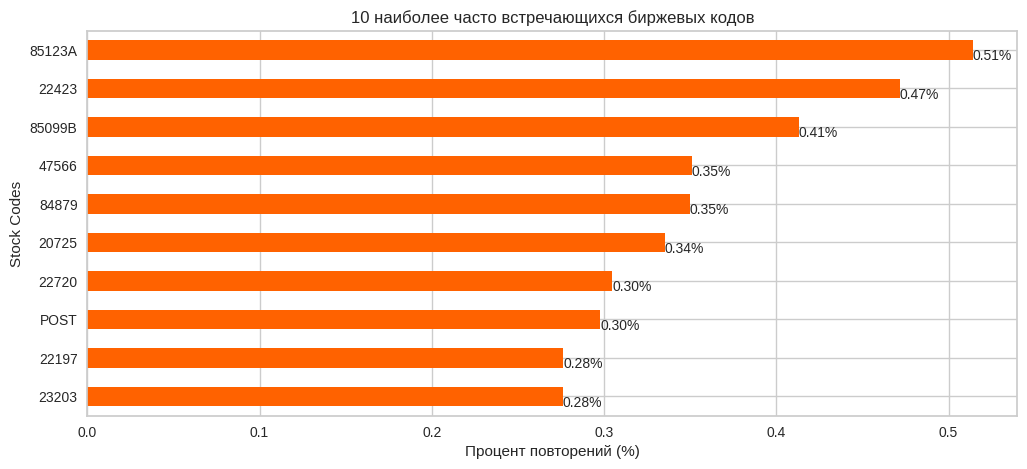

In [ ]:
# 10 наиболее часто встречающихся биржевых кодов
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff6200')

for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('10 наиболее часто встречающихся биржевых кодов')
plt.xlabel('Процент повторений (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

- набор данных содержит 3684 уникальных кодов акций, что указывает на значительное разнообразие продуктов, доступных в розничном интернет-магазине. Это разнообразие потенциально может привести к выявлению отдельных групп клиентов с предпочтениями к разным типам продуктов. Популярные товары. Более пристальный взгляд на 10 наиболее частых кодов акций может дать представление о популярных продуктах или категориях, которые часто покупают покупатели.
- большинство биржевых кодов состоят из 5 или 6 символов, существуют некоторые аномалии, такие как код «POST». Эти аномалии могут представлять собой услуги или транзакции, не связанные с продуктами (например, почтовые расходы), а не фактические продукты.

Чтобы сохранить фокус проекта, который заключается в кластеризации на основе покупок продуктов и создании системы рекомендаций, эти аномалии следует дополнительно исследовать и, возможно, лечить соответствующим образом, чтобы обеспечить целостность данных.

Чтобы углубиться в выявление этих аномалий, изучим частоту количества числовых символов в биржевых кодах, что может дать представление о природе этих необычных записей

In [ ]:
# Поиск количества цифровых символов в каждом уникальном биржевом коде
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

print("Количество цифровых символов в каждом уникальном биржевом коде")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Количество цифровых символов в каждом уникальном биржевом коде
----------------------------------------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


Большинство уникальных кодов акций содержат ровно 5 цифровых символов, что, по-видимому, является стандартным форматом для представления кодов продуктов в этом наборе данных.

7 кодов акций не содержат цифровых символов, а 1 код акций содержит только 1 цифровой символ. Они явно отклоняются от стандартного формата и требуют дальнейшего изучения, чтобы понять их природу и то, представляют ли они действительные транзакции с продуктами. Теперь давайте определим биржевые коды, содержащие 0 или 1 числовой символ, чтобы лучше понять эти аномалии

In [ ]:
# Печать биржевых кодов с цифровыми символами 0 и 1
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


Посчитаем процент записей с этими аномальными кодами акций

In [ ]:
# Вычисление процента записей с этими биржевыми кодами
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100
print(f"Процент записей с аномальными кодами запасов {percentage_anomalous:.2f}%")

Процент записей с аномальными кодами запасов 0.48%


Эти коды, похоже, представляют собой транзакции, не связанные с продуктами, такие как BANK CHARGES, POST. Поскольку они не представляют собой фактические продукты и составляют очень небольшую часть набора данных, включение их в анализ может привести к зашумлению и исказить систему кластеризации и рекомендаций.

In [ ]:
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [ ]:
df.shape[0]

399689

## Очистка столбца с описаниями

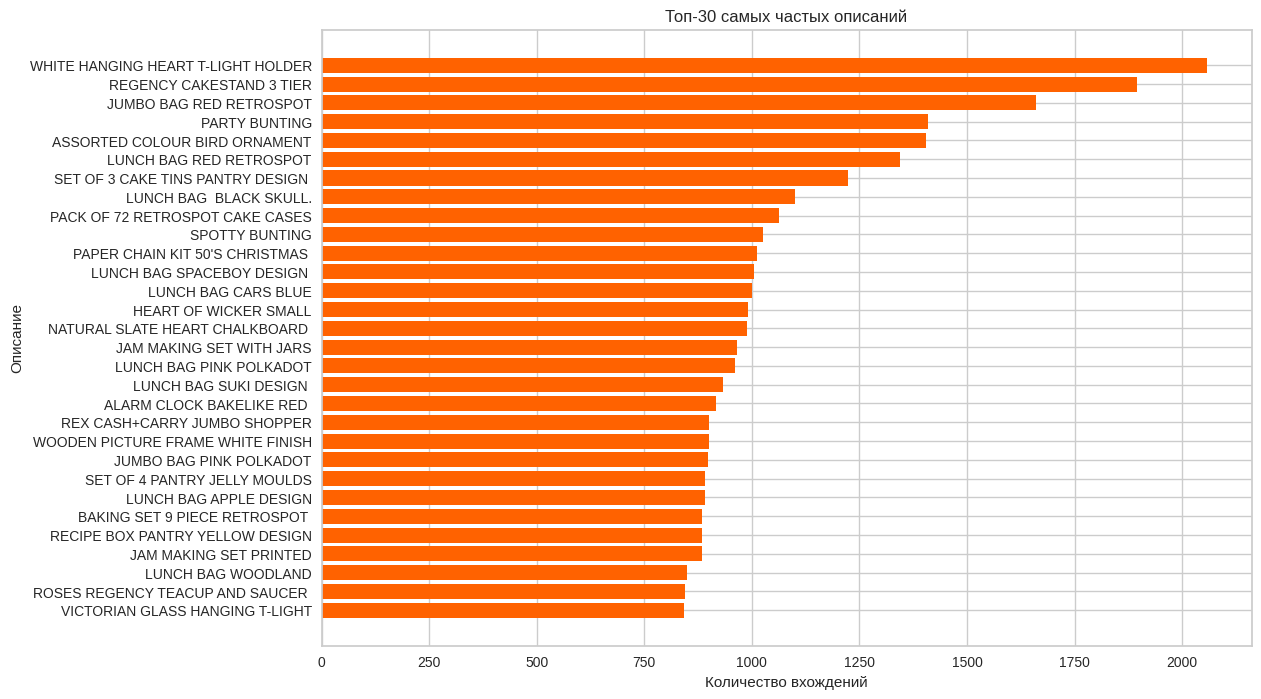

In [ ]:
# Вычисление встречаемости каждого уникального описания
description_counts = df['Description'].value_counts()

top_30_descriptions = description_counts[:30]

plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')
plt.xlabel('Количество вхождений')
plt.ylabel('Описание')
plt.title('Топ-30 самых частых описаний')
plt.show()

Наиболее частыми описаниями обычно являются предметы домашнего обихода, особенно кухонные принадлежности, пакеты для обеда и декоративные предметы.

Интересно, что все описания написаны заглавными буквами, что может быть стандартным форматом для ввода описаний продуктов в базу данных. Однако, стоит проверить, есть ли описания, введенные в нижнем регистре или в сочетании стилей регистра.

In [ ]:
# уникальные описания, содержащие символы нижнего регистра
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

print("уникальные описания, содержащие символы нижнего регистра")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

уникальные описания, содержащие символы нижнего регистра
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


При просмотре описаний, содержащих строчные буквы, становится очевидно, что некоторые записи не являются описаниями продуктов, например «Перевозка на следующий день» и «Изображение с высоким разрешением». Кажется, что эти записи не связаны с реальными продуктами и могут представлять другие типы информации или детали услуг.

- Удалим строки, в описаниях которых содержится информация, связанная с услугами, например «Перевозка на следующий день» и «Изображение в высоком разрешении», поскольку они не представляют собой реальные продукты и не будут способствовать созданию системы кластеризации и рекомендаций, которую мы стремимся создать.
- Для остальных описаний со смешанным регистром стандартизируем текст в верхний регистр, чтобы обеспечить единообразие во всем наборе данных. Это также поможет снизить вероятность дублирования записей с разными стилями регистра.

In [ ]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# процент записей с описаниями, относящимися к сервису
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

print(f"процент записей с описаниями, относящимися к сервису {service_related_percentage:.2f}%")


df = df[~df['Description'].isin(service_related_descriptions)]
# all descr to upper case
df['Description'] = df['Description'].str.upper()

процент записей с описаниями, относящимися к сервису 0.02%


In [ ]:
df.shape[0]

399606

Теперь взглянем на статистическое описание столбца UnitPrice

In [ ]:
df['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

Минимальное значение цены единицы продукции равно нулю. Это говорит о том, что в некоторых транзакциях цена за единицу равна нулю, что потенциально указывает на бесплатный товар или ошибку при вводе данных. Чтобы понять их природу, важно глубже изучить эти транзакции с нулевой ценой за единицу.

In [ ]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


Сделок с нулевой ценой за единицу относительно немного (33 сделки). Эти транзакции имеют большую вариативность количества участвующих товаров в диапазоне от 1 до 12540 со значительным стандартным отклонением.

In [ ]:
# Удаление записей с нулевой ценой за единицу, чтобы избежать потенциальных ошибок при вводе данных
df = df[df['UnitPrice'] > 0]

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df.shape[0]

399573

# Feature Engineering

## RFM Features

RFM — это метод, используемый для анализа ценности клиента и сегментации клиентской базы.
- Недавность (R) этот показатель показывает, как недавно клиент совершил покупку. Более низкое значение давности означает, что клиент совершил покупку совсем недавно, что указывает на более высокий уровень взаимодействия с брендом.
- Частота (F) этот показатель показывает, как часто клиент совершает покупку в течение определенного периода. Более высокое значение частоты указывает на клиента, который чаще взаимодействует с бизнесом, что предполагает более высокую лояльность или удовлетворенность.
- Денежный (M) этот показатель представляет собой общую сумму денег, потраченную клиентом за определенный период. Клиенты, имеющие более высокую денежную стоимость, внесли больший вклад в бизнес, что указывает на их потенциальную высокую пожизненную ценность.

Вместе эти показатели помогают понять покупательское поведение и предпочтения клиентов, что имеет решающее значение для персонализации маркетинговых стратегий и создания системы рекомендаций.

## Recency (R)

На этом этапе мы фокусируемся на понимании того, как недавно клиент совершил покупку. Это важнейший аспект сегментации клиентов, поскольку он помогает определить уровень вовлеченности клиентов.
- Количество дней с момента последней покупки. Более низкое значение указывает на то, что клиент совершил покупку недавно, что подразумевает более высокий уровень вовлеченности в бизнес, тогда как более высокое значение может указывать на прекращение или снижение вовлеченности. Понимая давность покупок, компании могут адаптировать свои маркетинговые стратегии для повторного привлечения клиентов, которые давно не совершали покупок, потенциально увеличивая удержание клиентов и повышая их лояльность.

In [ ]:
# Преобразование даты выставления счета в тип даты и времени
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# выделяем только дату
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# самая раняя покупка для каждого клиента
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# самая последняя дата во всем наборе данных
most_recent_date = df['InvoiceDay'].max()

# Преобразование лня выставления счета в тип даты и времени перед вычитанием
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# число дней с момента последней покупки для каждого покупателя
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# удаляем лишнее
customer_data.drop(columns=['InvoiceDay'], inplace=True)

Теперь фрейм данных customer_data содержит столбец Days_Since_Last_Purchas

In [ ]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


customer_data, в конечном итоге будет содержать все клиентоориентированные фичи, которые мы планируем создать.

## Frequency (F)

Создадим 2 фичи, которые количественно оценят частоту взаимодействия покупателя с продавцом
- Всего транзакций. Это помогает понять уровень взаимодействия покупателя с продавцом.
- Всего куплено продуктов. Это дает представление о покупательском поведении клиентов с точки зрения объема приобретенных продуктов.

In [ ]:
# количество операций для каждого клиента
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# количество купленных товаров для каждого покупателя
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# слияние
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


## Monetary (M)

Создадим еще 2 фичи, которые представляют денежный аспект транзакций клиента
- Общие расходы. Она рассчитывается как сумма произведения UnitPrice и Quantity для всех транзакций, совершенных клиентом. Показывает общий доход, полученный каждым клиентом, что является прямым показателем ценности клиента для бизнеса.
- Средняя стоимость транзакции. Эта фича рассчитывается как общие расходы, разделенные на общее количество транзакций для каждого клиента. Он указывает среднюю стоимость транзакции, осуществленной клиентом. Этот показатель полезен для понимания покупательского поведения клиентов в расчете на транзакцию, что может помочь в адаптации маркетинговых стратегий и предложений для различных сегментов клиентов на основе их средней структуры расходов

In [ ]:
# рассчет общих трат для каждого пользователя
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# среднее значение одной транзакции
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# добавление фичей
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


## Product Diversity

Посмотрим на разнообразие покупательского поведения клиентов. Понимание разнообразия продуктов может помочь в разработке персонализированных маркетинговых стратегий и рекомендаций по продуктам.
- Купленные уникальные продукты. Более высокое значение указывает на то, что у покупателя разнообразные вкусы или предпочтения, и он покупает широкий ассортимент товаров, тогда как более низкое значение может указывать на целенаправленное или конкретное предпочтение. Понимание разнообразия покупок продуктов может помочь сегментировать клиентов на основе разнообразия их покупок, что может стать решающим фактором при персонализации рекомендаций по продуктам.

In [ ]:
# количество уникальных товаров в покупках
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# слияние
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


## Behavioral Features

Поведенческие фичи дадут нам представление о предпочтениях клиентов относительно того, когда им нравится делать покупки, что может иметь решающее значение для персонализации их покупательского опыта.

- Среднее количество дней между покупками. Понимание этого может помочь спрогнозировать, когда клиент, скорее всего, совершит следующую покупку, что может стать решающим показателем для целевого маркетинга и персонализированных рекламных акций.
- День любимых покупок. Эта информация может помочь определить предпочтительные дни покупок для различных сегментов клиентов, что можно использовать для оптимизации маркетинговых стратегий и рекламных акций для разных дней недели.
- Любимый час покупок. Определение любимого часа для покупок может помочь оптимизировать время проведения маркетинговых кампаний и рекламных акций, чтобы они соответствовали времени, когда различные сегменты клиентов наиболее активны.

In [ ]:
# день недели
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# среднее количество дней между последовательными покупками
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# любимый день покупок на неделе
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# любимый час для покупок
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


## Geographic Features

Добавим фичу, отражающую географическое расположение клиентов.
- Страна. Включение данных по стране может помочь нам понять модели и предпочтения покупок в конкретных регионах. В разных регионах могут быть разные предпочтения и покупательское поведение, что может иметь решающее значение для персонализации маркетинговых стратегий и планирования запасов. Кроме того, это может сыграть важную роль в оптимизации логистики и цепочки поставок, особенно для интернет-магазина, где доставка и доставка играют важную роль.

In [ ]:
df['Country'].value_counts(normalize=True).head()

Country
United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: proportion, dtype: float64

Учитывая, что значительная часть (89%) транзакций происходит из Великобритании, мы могли бы рассмотреть возможность создания двоичной функции, указывающей, происходит ли транзакция из Великобритании или нет. Этот подход потенциально может упростить процесс кластеризации без потери важной географической информации, особенно при рассмотрении применения таких алгоритмов, как K-средние, которые чувствительны к размерности пространства признаков.

In [ ]:
# группировка по клиентам и странам. получение количества транзакций для каждого покупателя
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# страна с наибольшим числом транзакций для каждого клиента
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# флаг, из ВБ или нет
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [ ]:
customer_data['Is_UK'].value_counts()

Is_UK
1    3866
0     416
Name: count, dtype: int64

## Cancellation Insights

- Частота отмены. Понимание частоты отмены может помочь нам выявить клиентов, которые с большей вероятностью отменяют транзакции. Это может быть индикатором неудовлетворенности или других проблем, и понимание этого может помочь нам разработать стратегии, позволяющие сократить количество отмен и повысить удовлетворенность клиентов.
- Коэффициент отмены. Эта метрика дает нормализованное представление о поведении отмены. Высокий процент отказов может указывать на неудовлетворенный сегмент клиентов. Определив эти сегменты, мы можем разработать целевые стратегии, позволяющие улучшить качество их покупок и потенциально снизить процент отказов от покупок.

In [ ]:
# общее количество операций для каждого клиента
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# число отмененных транзакций для каждого клиента
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

customer_data['Cancellation_Frequency'].fillna(0, inplace=True)
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


## Seasonality & Trends

- Monthly_Spending_Mean Это помогает нам оценить общую покупательскую привычку каждого клиента. Более высокое среднее значение указывает на клиента, который тратит больше и потенциально проявляет интерес к продуктам премиум-класса, тогда как более низкое среднее значение может указывать на клиента, более экономного в плане бюджета.
- Monthly_Spending_Std. Более высокое значение сигнализирует о том, что расходы клиентов значительно колеблются от месяца к месяцу, что, возможно, указывает на спорадические крупные покупки. Напротив, более низкое значение предполагает более стабильные и последовательные привычки расходования средств. Понимание этой изменчивости может помочь в разработке персонализированных рекламных акций или скидок в периоды, когда ожидается, что люди будут тратить больше.
- Spending_Trend. Положительное значение указывает на тенденцию к увеличению расходов, возможно, указывая на растущую лояльность или удовлетворенность. И наоборот, отрицательная тенденция может сигнализировать о снижении интереса или удовлетворенности, подчеркивая необходимость стратегий повторного вовлечения. Значение, близкое к нулю, означает стабильные привычки расходования средств. Признание этих тенденций может помочь в разработке стратегий по сохранению или изменению структуры расходов клиентов, повышая эффективность маркетинговых кампаний.

In [ ]:
# извлекаем месяц
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# растраты для каждого пользователя по месяцам
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# сезонность покупок
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

def calculate_trend(spend_data):
    # Если имеется более одной точки данных, мы вычисляем тренд с помощью линейной регрессии
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # Если есть только одна точка данных, тренд вычислить невозможно, следовательно, мы возвращаем 0
    else:
        return 0

# Примените функцию calculate_trend, чтобы найти тенденцию расходов для каждого клиента
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [ ]:
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)
customer_data = customer_data.convert_dtypes()

In [ ]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0
5,12352.0,36,8,463,1265.41,158.17625,57,3.13253,1,14,0,1,0.125,316.3525,134.700629,9.351
6,12353.0,204,1,20,89.0,89.0,4,0.0,3,17,0,0,0.0,89.0,0.0,0.0
7,12354.0,232,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0,1079.4,0.0,0.0
8,12355.0,214,1,240,459.4,459.4,13,0.0,0,13,0,0,0.0,459.4,0.0,0.0
9,12356.0,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0,0.0,829.143333,991.462585,-944.635


In [ ]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   Days_Since_Last_Purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   Total_Spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Products_Purchased       4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int32  
 9   Hour                            4282 non-null   Int32  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

- CustomerID Идентификатор, уникально присваиваемый каждому клиенту и используемый для различения отдельных клиентов.
- Days_Since_Last_Purchase Число дней, прошедших с момента последней покупки клиента.
- Total_Transactions Общее количество транзакций, совершенных клиентом.
- Total_Products_Purchased Общее количество продуктов, приобретенных клиентом по всем транзакциям.
- Total_Spend Общая сумма денег, потраченная клиентом по всем транзакциям.
- Average_Transaction_Value Средняя стоимость транзакций клиента, рассчитываемая как общие расходы, разделенные на количество транзакций.
- Unique_Products_Purchased Количество различных продуктов, приобретенных клиентом.
- Average_Days_Between_Purchases Среднее количество дней между последовательными покупками, совершенными клиентом.
- Day_Of_Week День недели, когда покупатель предпочитает делать покупки, представленный в числовом виде (0 — понедельник, 6 — воскресенье).
- Hour Час дня, когда покупатель предпочитает совершать покупки, представленный в 24-часовом формате.
- Is_UK Бинарная переменная, указывающая, находится ли клиент в Великобритании (1) или нет (0).
- Cancellation_Frequency Общее количество транзакций, которые клиент отменил.
- Cancellation_Rate Доля транзакций, которые клиент отменил, рассчитывается как частота отмены, деленная на общее количество транзакций.
- Monthly_Spending_Mean Среднемесячные расходы клиента.
- Monthly_Spending_Std Стандартное отклонение ежемесячных расходов клиента, указывающее на изменчивость структуры их расходов.
- Spending_Trend Числовое представление тенденции расходов клиента с течением времени. Положительное значение указывает на тенденцию к увеличению, отрицательное значение указывает на тенденцию к снижению, а значение, близкое к нулю, указывает на стабильную тенденцию.

# Обнаружение и обработка выбросов

При кластеризации K-средних алгоритм чувствителен как к масштабу данных, так и к наличию выбросов, поскольку они могут существенно влиять на положение центроидов, что потенциально может привести к неправильному назначению кластеров. Однако, учитывая контекст этого проекта, где конечной целью является понимание поведения и предпочтений клиентов с помощью кластеризации K-средних, было бы более разумно решить проблему выбросов после этапа разработки функций, на котором мы создаем набор данных, ориентированный на клиента.

In [ ]:
# показатель загрязнения 0,05
model = IsolationForest(contamination=0.05, random_state=0)

customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Создаем новый столбец для определения выбросов (1 для входящих значений и -1 для посторонних значений)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


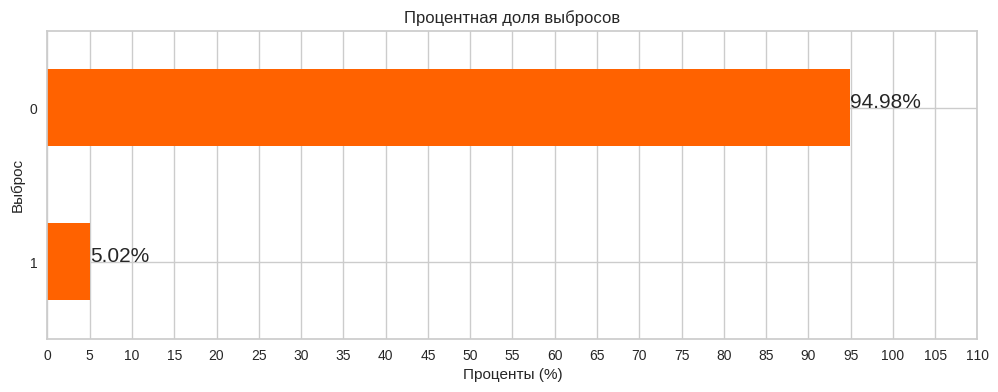

In [ ]:
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Процентная доля выбросов')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Проценты (%)')
plt.ylabel('Выброс')
plt.gca().invert_yaxis()
plt.show()

По графику видно, что около 5% клиентов были идентифицированы как выбросы. Этот процент представляется разумным, он не слишком высок для потери значительного объема данных и не слишком низок для сохранения потенциально зашумленных точек данных. Это говорит о том, что алгоритм изолирующего леса хорошо зарекомендовал себя при выявлении умеренного процента отклонений от нормы, что будет иметь решающее значение для уточнения нашей сегментации клиентов.

In [ ]:
# выделяем выбросы из выборки
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# удаляем выбросы из основной выборки
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# удаляем лишние столбцы
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# обновляем индексы
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [ ]:
# количество строк в очищенном датасете
customer_data_cleaned.shape[0]

4067

# Корреляционный анализ

Наличие мультиколлинеарности, при которой признаки сильно коррелируют, потенциально может повлиять на процесс кластеризации, не позволяя модели изучать фактические закономерности, лежащие в основе данных, поскольку признаки не предоставляют уникальной информации. Это может привести к тому, что кластеры будут плохо разделены и не будут иметь смысла.

Если мы определяем мультиколлинеарность, мы можем использовать методы уменьшения размерности, такие как PCA. Эти методы помогают нейтрализовать эффект мультиколлинеарности, преобразуя коррелированные признаки в новый набор некоррелированных переменных, сохраняя большую часть дисперсии исходных данных.

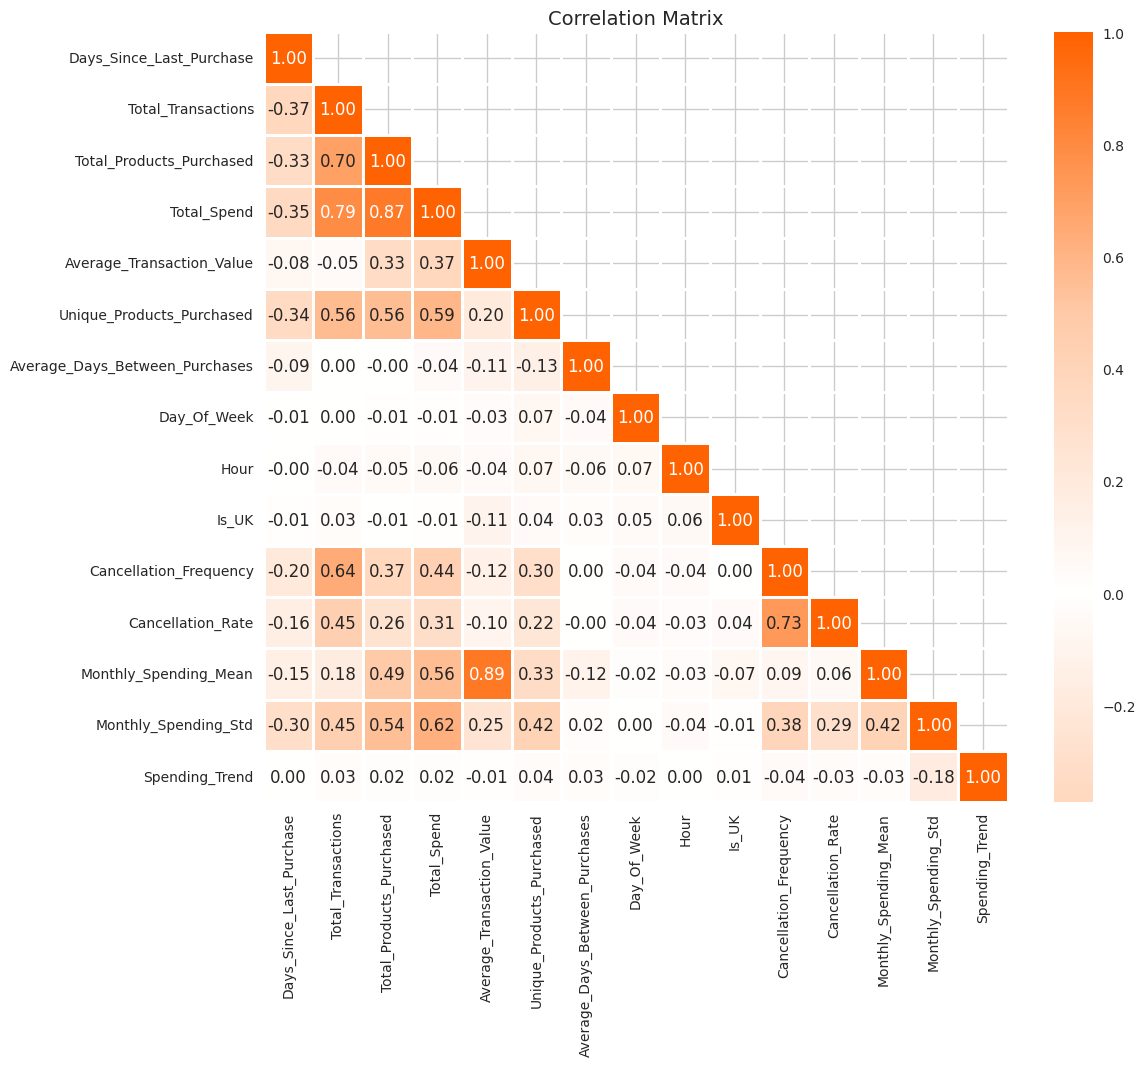

In [ ]:
# построение корреляционной матрицы
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

sns.set_style('whitegrid')
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# отображаем только нижнюю часть диаграммы, так как матрица корреляций получается зеркальной по диагонали
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

Некоторые признаки имеют высокую корреляцию:

- Monthly_Spending_Mean и Average_Transaction_Value
- Total_Spend и Total_Products_Purchased
- Total_Transactions и Total_Spend
- Cancellation_Rate и Cancellation_Frequency
- Total_Transactions и Total_Products_Purchased

Эти высокие корреляции указывают на то, что эти переменные тесно связаны друг с другом, что подразумевает определенную степень мультиколлинеарности.

Методы уменьшения размерности, такие как PCA, могут помочь в создании набора некоррелированных переменных. Это поможет в создании более стабильных кластеров в процессе кластеризации KMeans.

# Feature Scaling

При формировании кластеров K-средние значения опираются на расстояния между точками данных. Если объекты имеют разный масштаб, то это приводит к диспропорции данных, а как следствие к неправильным группировкам.

Для сбалансированности данных необходимо их стандартизировать, привести к общему виду. Необходимо преобразовать объекты так, чтобы среднее значение было равно 0, а стандартное отклонение - 1. Но не все признаки требуют масштабирования

Признаки без масштабирования:

- CustomerID: Эта функция является просто идентификатором клиентов и не содержит никакой значимой информации для кластеризации
- Is_UK: Это двоичный параметр, указывающий, из Великобритании клиент или нет
- Day_Of_Week: Эта функция отображает наиболее частый день недели, в течение которого клиент совершал транзакции. Поскольку это категориальная функция, представленная целыми числами (от 1 до 7), ее масштабирование не требуется.

In [ ]:
scaler = StandardScaler()

# столбцы исключения
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

customer_data_scaled = customer_data_cleaned.copy()
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.345802,-0.477589,-0.754491,-0.813464,-1.317106,-0.908471,-0.310564,1,-1.086929,1,0.420541,0.417623,-1.329018,-0.713318,0.090868
1,12347.0,-0.905575,0.707930,2.005048,2.366920,1.528132,0.815119,-0.128438,1,0.647126,0,-0.545753,-0.432111,0.989511,1.259961,0.116774
2,12348.0,-0.170744,-0.003381,1.863591,0.247087,0.343279,-0.570512,0.672476,3,2.814696,0,-0.545753,-0.432111,0.023997,0.466213,-0.491708
3,12349.0,-0.744516,-0.714692,-0.047205,0.262074,5.418285,0.291283,-0.310564,0,-1.520443,0,-0.545753,-0.432111,4.159521,-0.713318,0.090868
4,12350.0,2.194809,-0.714692,-0.534446,-0.596223,0.043327,-0.655002,-0.310564,2,1.514154,0,-0.545753,-0.432111,-0.220428,-0.713318,0.090868


# Понижение размерности

Приемущества понижения размерности:

- Улучшенная кластеризация

Уменьшая размерность, мы можем помочь K-средним находить более компактные и хорошо разделенные кластеры.

- Снижение уровня шума

Сосредоточившись только на наиболее важных функциях, мы потенциально можем устранить шум в данных, что приведет к созданию более точных и стабильных кластеров

- Улучшенная визуализация

В контексте сегментации клиентов возможность визуализировать группы клиентов в двух или трех измерениях может обеспечить интуитивное понимание.

- Повышение эффективности вычислений

Уменьшение количества объектов может ускорить время вычислений в процессе моделирования, что делает наш алгоритм кластеризации более эффективным.

PCA хорошо фиксирует линейные зависимости в данных, что особенно актуально, учитывая мультиколлинеарность, которую мы выявили в нашем наборе данных. Это позволяет нам сократить количество объектов в наборе данных, сохраняя при этом значительный объем информации, что делает анализ точным и интерпретируемым.

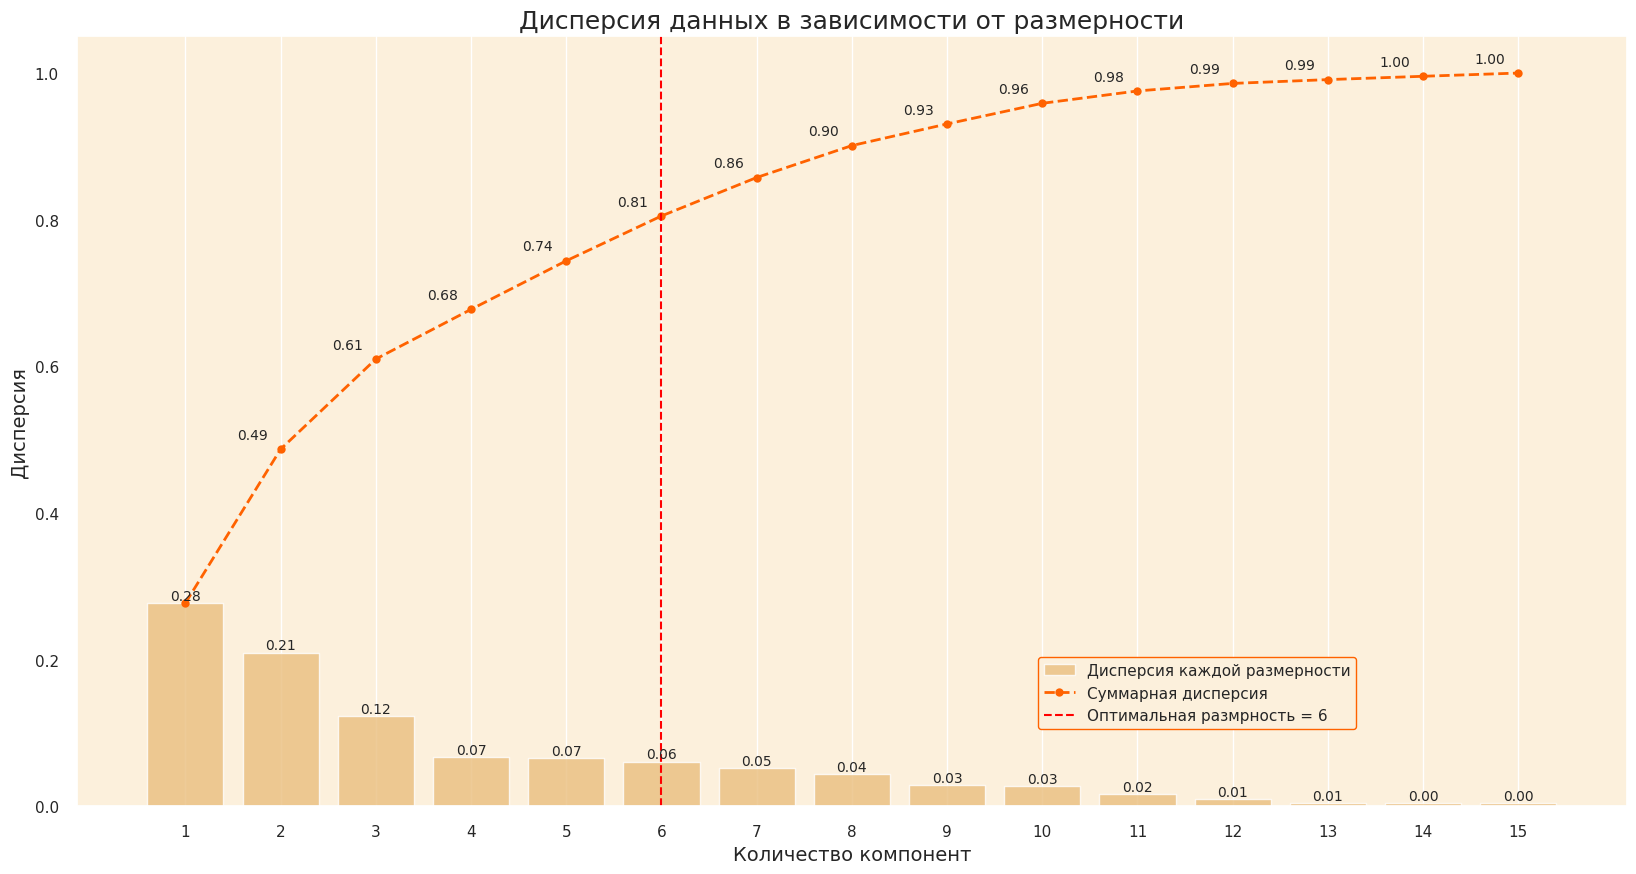

In [ ]:
customer_data_scaled.set_index('CustomerID', inplace=True)

pca = PCA().fit(customer_data_scaled)

# сумма дисперсии
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# пониженная размерность
optimal_k = 6

sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')
plt.figure(figsize=(20, 10))

barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Оптимальная размерность = {optimal_k}')
plt.xlabel('Количество компонент', fontsize=14)
plt.ylabel('Дисперсия', fontsize=14)
plt.title('Дисперсия данных в зависимости от размерности', fontsize=18)
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Дисперсия каждой размерности', 'Суммарная дисперсия', f'Оптимальная размрность = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

Первый компонент объясняет приблизительно 28% дисперсии

Первые два компонента в совокупности объясняют около 49% дисперсии

Первые три компонента объясняют примерно 61% дисперсии и так далее

Из графика мы можем видеть, что увеличение совокупной дисперсии начинает замедляться после 6-го компонента (около 81% от общей дисперсии)

Необходимо сохранить достаточный объем информации, чтобы эффективно идентифицировать отдельные группы клиентов. Сохранение первых 6 компонентов может быть сбалансированным выбором, поскольку они вместе объясняют значительную часть общей дисперсии, уменьшая при этом размерность набора данных

In [ ]:
pca = PCA(n_components=6)
customer_data_pca = pca.fit_transform(customer_data_scaled)

# создание нового дф с фичами PC1, PC2...
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# добавление CustomerID
customer_data_pca.index = customer_data_scaled.index

In [ ]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.186469,-1.705370,-1.576745,1.008187,-0.411803,-1.658012
12347.0,3.290264,-1.387375,1.923310,-0.930990,-0.010591,0.873150
12348.0,0.584684,0.585019,0.664727,-0.655411,-0.470280,2.306657
12349.0,1.791116,-2.695652,5.850040,0.853418,0.677111,-1.520098
12350.0,-1.997139,-0.542639,0.578781,0.183682,-1.484838,0.062672


Для демонстрации работы алгоритма PCA можно вывести коэффициенты, соответствующие каждому основному компоненту, чтобы лучше понять преобразование

In [ ]:
# функция для выделения 3-х верхних абсолютных значений в каждом столбце
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.217859,-0.013986,0.067660,0.273430,-0.240968,-0.373059
Total_Transactions,0.380301,0.014759,-0.259180,-0.138165,-0.017356,-0.028257
Total_Products_Purchased,0.401425,0.007365,0.069133,-0.134806,0.057476,-0.013373
Total_Spend,0.431260,0.010159,0.065165,-0.092047,0.025202,-0.036947
Average_Transaction_Value,0.176225,-0.015544,0.589050,0.114307,0.021847,-0.101738
Unique_Products_Purchased,0.324992,0.063346,0.014010,-0.230502,-0.193981,0.124604
Average_Days_Between_Purchases,-0.022600,-0.036007,-0.127341,-0.160627,0.753462,0.211787
Day_Of_Week,-0.026572,0.994650,-0.006591,0.028870,0.058359,-0.060799
Hour,-0.024259,0.056388,-0.002019,-0.226832,-0.528881,0.621915
Is_UK,-0.001014,0.007435,-0.018378,-0.013419,-0.005353,0.014384


# Кластеризация K-Means

K-Means - это алгоритм машинного обучения без контроля, который группирует данные в заданное количество групп (K) путем минимизации внутрикластерной суммы квадратов (WCSS). Алгоритм итеративно привязывает каждую точку данных к ближайшему центроиду, затем обновляет центроиды, вычисляя среднее значение для всех назначенных точек. Процесс повторяется до тех пор, пока не будет достигнута сходимость или критерий остановки.

Чтобы определить оптимальное количество кластеров (k) для сегментации клиентов, я рассмотрю два известных метода:

- Метод локтя

- Метод силуэта

### Метод локтя

Метод локтя включает в себя перебор данных и создание кластеров для различных значений k. Алгоритм k-means вычисляет сумму квадратов расстояний между каждой точкой данных и назначенным ей центроидом кластера, известную как показатель инерции (WCSS). Точка изгиба на графике представляет собой значение k, при котором уменьшение инерции, достигаемое за счет увеличения k, становится незначительным, что указывает на оптимальную точку остановки для данного количества кластеров.

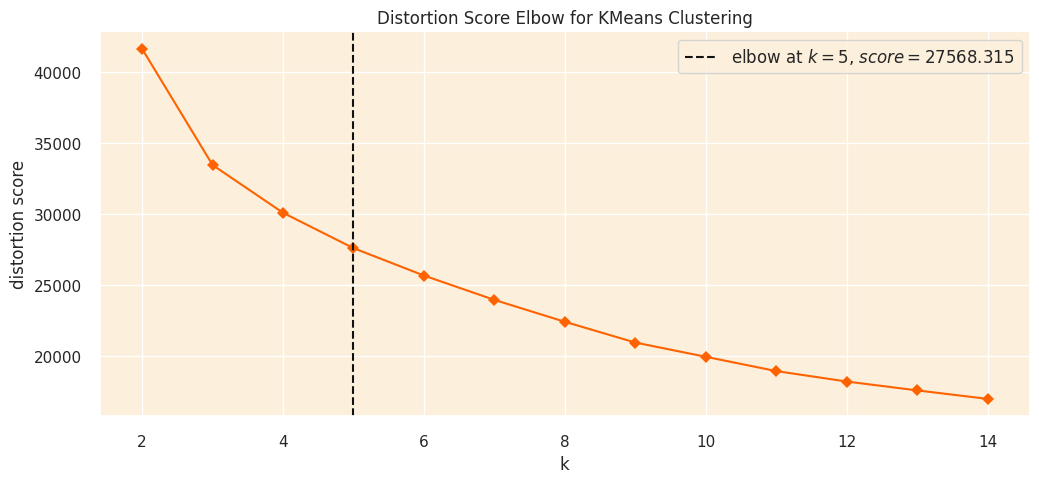

In [ ]:
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})
sns.set_palette(['#ff6200'])

km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

fig, ax = plt.subplots(figsize=(12, 5))
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)
visualizer.fit(customer_data_pca)
visualizer.show();

На графике мы видим, что инерция продолжает значительно уменьшаться вплоть до k=5, что указывает на то, что оптимальное значение k может составлять от 3 до 7. Чтобы выбрать наилучший вариант из этого диапазона, мы можем использовать силуэтный анализ, еще один метод оценки качества кластера.

### Метод силуэта

Он вычисляет коэффициент силуэта для каждой точки данных, который определяет, насколько точка похожа на свой собственный кластер по сравнению с другими кластерами.

Рассчет коэффицента силуэта:
- a(i) - среднее расстояние между точкой i и всеми остальными точками в пределах ее кластера
- b(i) - среднее расстояние между точкой i и всеми точками в ближайшем к ней кластере

s(i)=b(i)−a(i)max(b(i),a(i))

Метод силуэта оценивает качество кластеров, принимая во внимание как сплоченность внутри кластеров, так и их отделенность от других кластеров. Это обеспечивает более полную оценку эффективности кластеризации по сравнению с методом Локтя, который учитывает только инерцию (сумму квадратов расстояний внутри кластеров).

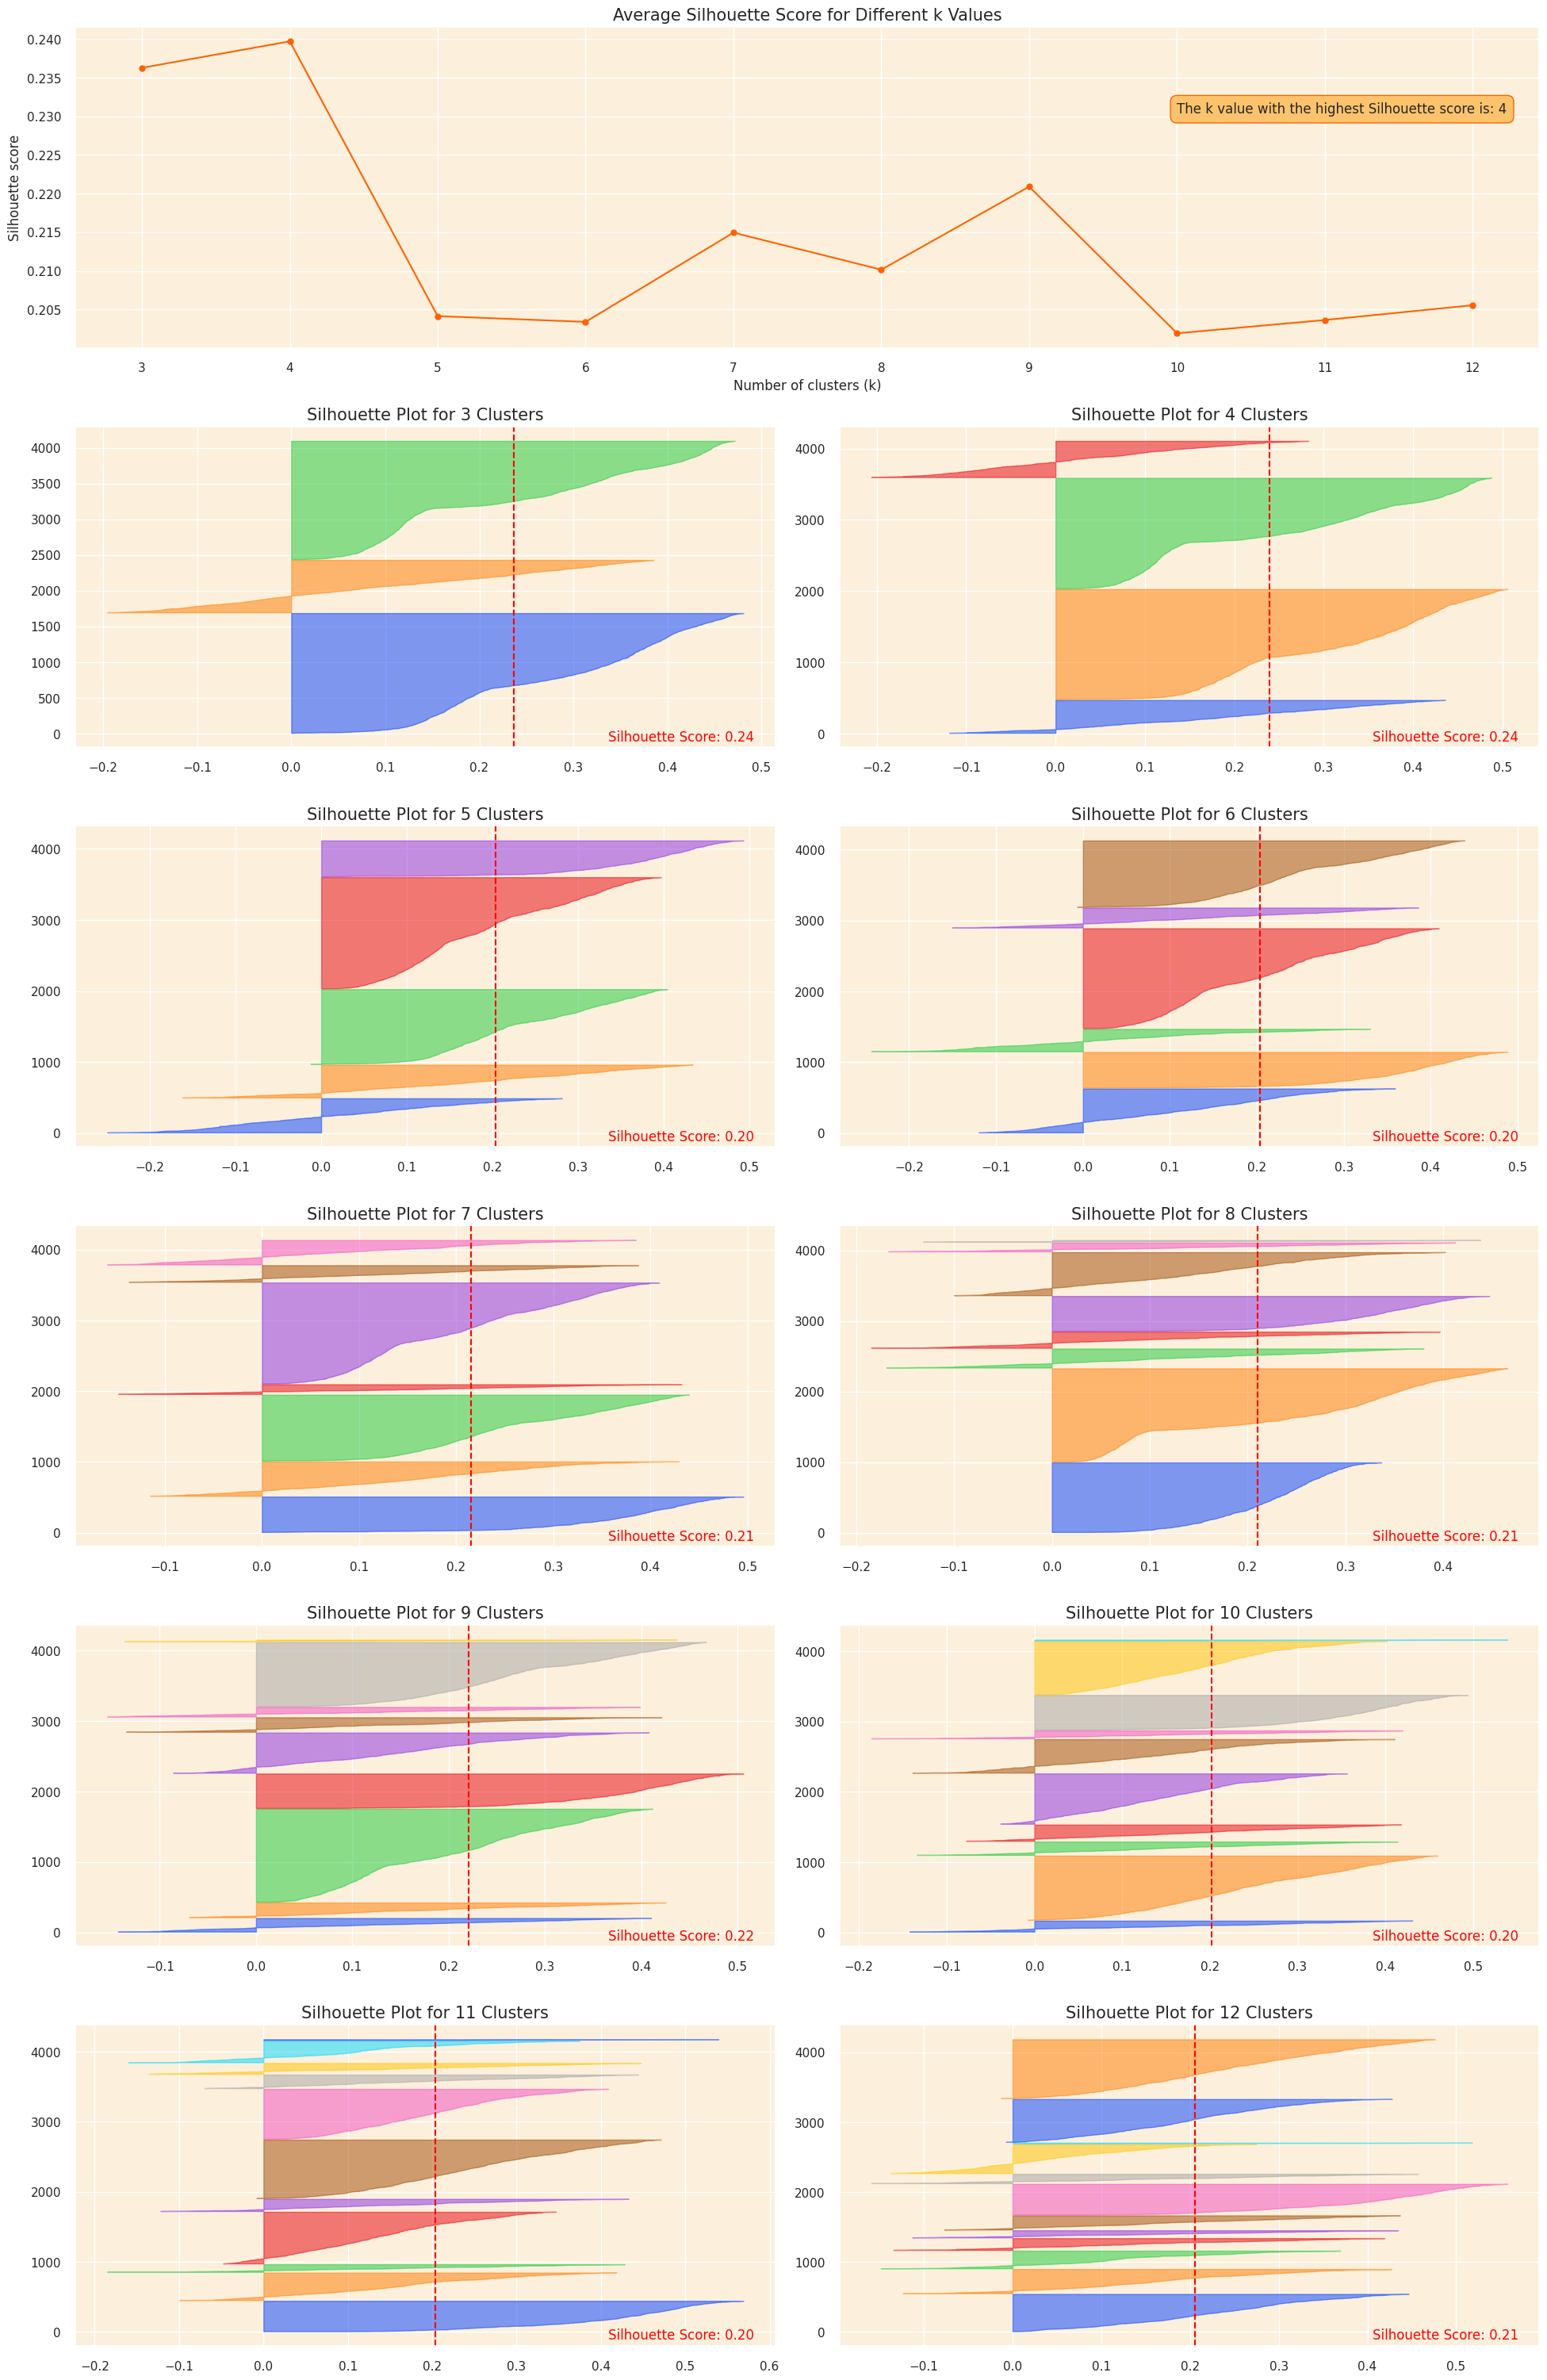

In [ ]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Расчитывает количество кластеров с использованием метода силуэта
    """

    plt.figure(figsize=figsize)
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    first_plot = plt.subplot(grid[0, :])

    sns.set_palette(['darkorange'])

    silhouette_scores = []

    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # добавление оптимального числа кластеров k
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))


    # расчет коэффициента для каждого кластера k
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # добавление значения коэффициента силуэта
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

Исходя из коэффициента силуэта, можно заметить, что наилучшим числом кластеров является 3

# Модель K-Мeans

Алгоритм K-Means — это метод машинного обучения для кластеризации данных. Он пытается разделить набор данных на заранее заданное число кластеров (K) таким образом, чтобы точки внутри каждого кластера были похожи друг на друга, а точки между кластерами — различались. Алгоритм начинается с инициализации центров кластеров. Затем он выполняет два шага до сходимости:

- Назначает каждую точку к ближайшему центру кластера.
- Перемещает центры кластеров в центр масс точек, принадлежащих каждому кластеру.

Эти шаги повторяются до тех пор, пока центры кластеров перестают изменяться или изменение становится незначительным. Один из основных недостатков алгоритма — необходимость заранее задавать количество кластеров, что может быть непростой задачей. Кроме того, K-Means может сойтись к локальному минимуму, в зависимости от начального положения центров кластеров. Тем не менее, он широко используется благодаря своей простоте и эффективности.

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# диапозон значений каждого кластера
cluster_frequencies = Counter(kmeans.labels_)

# Применение новых лейблов
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Изменяем метки отображения кластеров
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

customer_data_cleaned['cluster'] = new_labels
customer_data_pca['cluster'] = new_labels

In [ ]:
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,2
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1


### Оценка качества кластеризации

Это этап оценки, чтобы оценить качество сформированных кластеров. Этот шаг необходим для проверки эффективности кластеризации и обеспечения согласованности и четкого разделения кластеров.

Будет использоваться:
- Визуализация
- Оценка Silhouette
- Оценка Калински Харабаша
- Оценка Дэвиса Боулдина

Линейчатый график для визуализации процентного соотношения клиентов в каждом кластере, что помогает понять, являются ли кластеры сбалансированными и значимыми

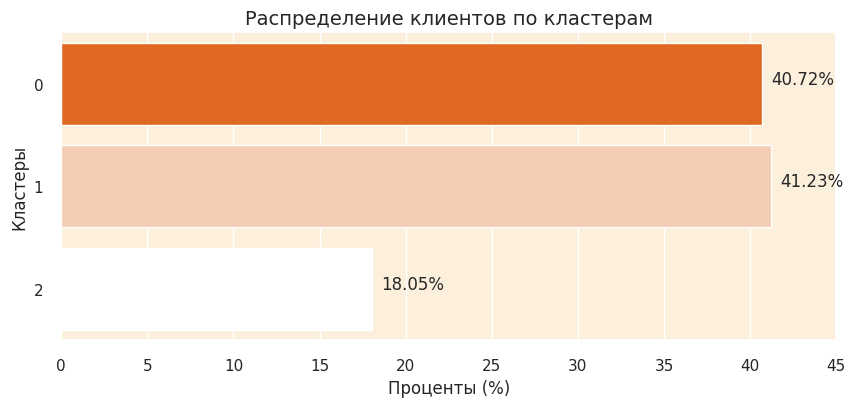

In [ ]:
# Процент клиентов в каждом кластере
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# добавление шкал процентов
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Распределение клиентов по кластерам', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Проценты (%)')
plt.ylabel('Кластеры')

plt.show()

Такое сбалансированное распределение указывает на то, что наш процесс кластеризации был в значительной степени успешным в выявлении значимых закономерностей в данных, а не просто в группировании шума или выбросов.

### Расчет метрик

- Коэффициент силуэта - показатель, позволяющий оценить расстояние между кластерами. Более высокие значения указывают на лучшее разделение кластеров. Он варьируется от -1 до 1.
- Коэффициент Калински Харабаша - используется для оценки дисперсии между кластерами и внутри них. Более высокий балл указывает на более четкие кластеры.
- Коэффициент Балл Дэвиса Боулдина - среднее сходство между каждым кластером и наиболее похожим кластером. Более низкие значения указывают на лучшее разделение кластеров.

In [ ]:
# количество клиентов
num_observations = len(customer_data_pca)

# выделение лейблов кластеров
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# расчет метрик
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4067         |
|    Silhouette Score     | 0.23627137022779904 |
| Calinski Harabasz Score | 1257.1794962921563  |
|  Davies Bouldin Score   | 1.3684055372996033  |
+-------------------------+---------------------+


- Оценка силуэта, равная приблизительно 0,236, хотя и не близка к 1, все же указывает на значительную степень разделения между кластерами. Это говорит о том, что кластеры в некоторой степени отличаются друг от друга, но между ними могут быть небольшие совпадения.

- Показатель Calinski Harabasz равен 1257,17, что является достаточно высоким показателем, указывающим на то, что кластеры хорошо определены. Более высокий балл по этому показателю в целом свидетельствует о более точном определении кластеров, что означает, что при кластеризации удалось найти существенную структуру в данных.

- Оценка по шкале Дэвиса Боулдена, равная 1,36, является приемлемой и указывает на умеренный уровень сходства между каждым кластером и наиболее похожим из них. Чем ниже оценка, тем лучше, поскольку она указывает на меньшее сходство между кластерами, и, таким образом, наша оценка позволяет говорить о достаточном разделении кластеров.

В заключение, полученные показатели свидетельствуют о том, что кластеризация выполнена качественно, кластеры четко определены и достаточно разделены. Однако, возможно, еще есть возможности для дальнейшей оптимизации для улучшения разделения и определения кластеров, возможно, путем использования других алгоритмов кластеризации и уменьшения размерности.

# AutoEncoder модель

Алгоритм AutoEncoder - это метод обучения без учителя в области глубокого обучения, который используется для изучения эффективного кодирования данных. Он состоит из двух основных компонентов: кодировщика (encoder) и декодировщика (decoder). Цель AutoEncoder состоит в том, чтобы эффективно сжать входные данные в некоторое скрытое представление и затем восстановить их обратно.

Вначале, кодировщик принимает входные данные и преобразует их в скрытое представление меньшей размерности. Это скрытое представление обычно называется "код" и содержит в себе наиболее важные признаки и характеристики входных данных. Затем, декодировщик принимает этот код и пытается восстановить исходные данные обратно.

В процессе обучения, AutoEncoder минимизирует функцию потерь между входными данными и их реконструкцией. Это заставляет модель изучать более информативное представление входных данных, так как она должна сохранять важные характеристики для успешной реконструкции.

AutoEncoder может быть использован для различных целей, включая уменьшение размерности данных, удаление шума из изображений, генерацию новых данных и многое другое. Его эффективность зависит от архитектуры и гиперпараметров модели, а также от качества данных и задачи, которую необходимо решить.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
import numpy as np

# Пример набора данных
# Здесь X_train - набор данных для обучения автоэнкодера
X_train = customer_data_pca.to_numpy()

# Определение автоэнкодера
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(True),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Параметры модели и обучение
input_size = X_train.shape[1] # Размер входных данных
encoding_dim = 32 # Размерность кодированного представления
num_epochs = 50
learning_rate = 1e-3

model = Autoencoder(input_size, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение автоэнкодера
for epoch in range(num_epochs):
    input_data = torch.Tensor(X_train)
    output_data = model(input_data)
    loss = criterion(output_data, input_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Использование обученного автоэнкодера для извлечения признаков
encoded_data = model.encoder(torch.Tensor(X_train)).detach().numpy()

# Кластеризация с использованием KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(encoded_data)

# Предсказанные метки кластеров
cluster_labels = kmeans.labels_

# Вывод результата
print("Метки кластеров:", cluster_labels)

Epoch [10/50], Loss: 2.0740
Epoch [20/50], Loss: 1.8692
Epoch [30/50], Loss: 1.6730
Epoch [40/50], Loss: 1.5515
Epoch [50/50], Loss: 1.4877
Метки кластеров: [0 1 2 ... 2 1 0]


In [ ]:
customer_data_cleaned['cluster'] = cluster_labels
customer_data_pca['cluster'] = cluster_labels

In [ ]:
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,2
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,0


### Оценка качества кластеризации

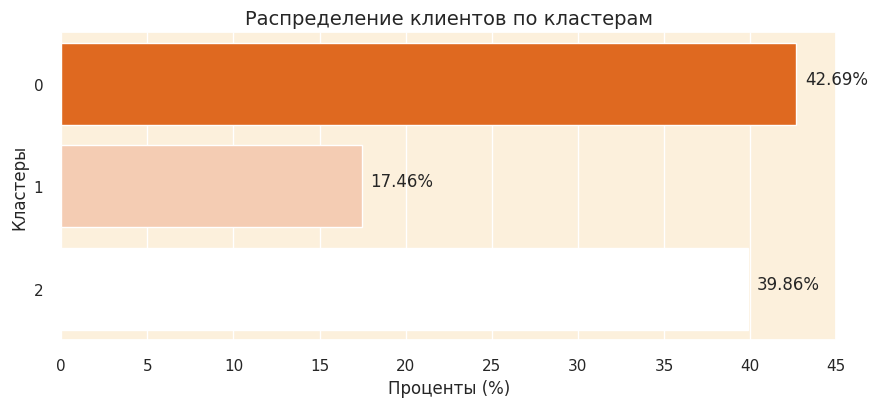

In [ ]:
# Процент клиентов в каждом кластере
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# добавление шкал процентов
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Распределение клиентов по кластерам', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Проценты (%)')
plt.ylabel('Кластеры')

plt.show()

Кластеры разбились почти также равномерно, что говорит о стабильном обучении модели. Необходимо посмотреть на метрики качества, чтобы выбрать лучшую модель

### Расчет метрик

In [ ]:
# количество клиентов
num_observations = len(customer_data_pca)

# выделение лейблов кластеров
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# расчет метрик
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4067         |
|    Silhouette Score     | 0.23403671615685057 |
| Calinski Harabasz Score | 1237.8378338741136  |
|  Davies Bouldin Score   | 1.3942201952717121  |
+-------------------------+---------------------+


- Оценка силуэта, равная 0,234, указывает на значительную степень разделения между кластерами. Это все же чуть меньше, чем аналогичная метрика у первой модели, но не критично.

- Показатель Calinski Harabasz равен 1237,83, показывает, что кластеры хорошо определены. Более высокий балл по этому показателю в целом свидетельствует о более точном определении кластеров, что говорит в пользу первой модели.

- Оценка по шкале Дэвиса Боулдена, равная 1,39, указывает на умеренный уровень сходства между каждым кластером и наиболее похожим из них. Чем ниже оценка, тем лучше, поскольку она указывает на меньшее сходство между кластерами, а это значит, что вторая модель показала себя лучше первой.

В целом модели показали очень схожий результат. Но модель глубокого обучения можно дальше оптимизировать и подстраивать под данные, поэтому ее выбор предпочтительнее.

# Анализ кластеризации

Необходимо проанализировать характеристики каждого кластера, чтобы понять особенности поведения и предпочтения различных клиентских сегментов, а также составить профиль каждого кластера, чтобы определить ключевые черты, которые определяют клиентов в каждом кластере.

Прежде всего, можно создать радарные диаграммы, чтобы визуализировать значения центроида каждого кластера для различных объектов. Это позволит быстро сравнить профили разных кластеров.Для построения радарных диаграмм важно сначала вычислить центроид для каждого кластера. Этот центроид представляет собой среднее значение для всех объектов в пределах определенного кластера. Это позволяет наглядно увидеть основные тенденции для каждого объекта в различных кластерах

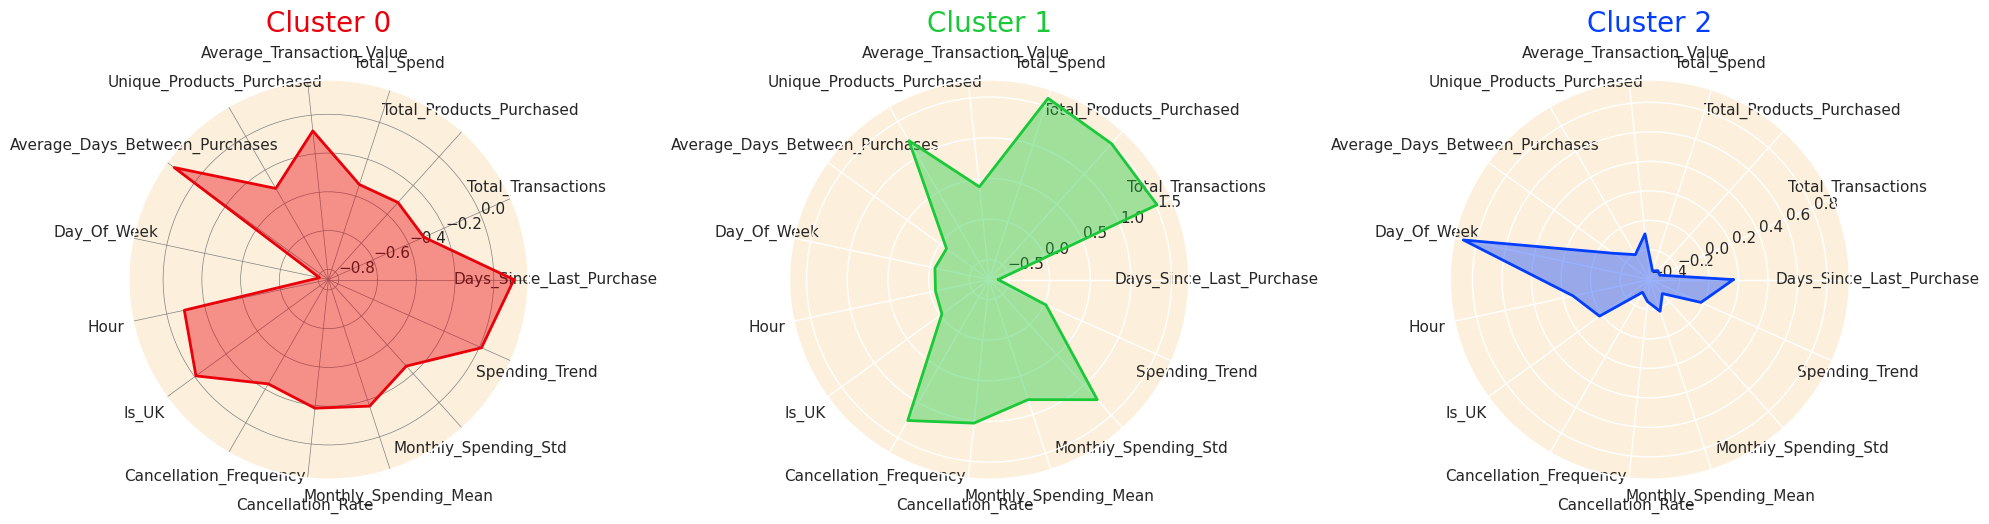

In [ ]:
df_customer = customer_data_cleaned.set_index('CustomerID')

# стандартизация данных
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# расчет центроид для каждого кластера
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# функция для создания радарной диаграмы
def create_radar_chart(ax, angles, data, color, cluster):
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')

    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# расчет поворота граней графика
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# График имеет круглую форму, поэтому нам нужно соединить начало с концом
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)
colors = ['#e8000b', '#1ac938', '#023eff']

for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # завершить цикл
    create_radar_chart(ax[i], angles, data, color, i)

ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# добавить сетку
ax[0].grid(color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()


- Кластер 0

Профиль: Случайные покупатели, предпочитающие совершать покупки в выходные дни

Клиенты в этом кластере, как правило, тратят меньше, совершая меньшее количество транзакций и приобретая меньше товаров.
У них есть небольшая тенденция совершать покупки в выходные дни, о чем свидетельствует очень высокое значение Day_of_Week.
Тенденция к их расходам относительно стабильна, но имеет тенденцию к снижению, и у них низкие ежемесячные колебания расходов (low Monthly_Spending_Std).
У этих клиентов было не так много случаев отмены заказа, что свидетельствует о низкой частоте отмены заказа.
Средняя стоимость транзакции ниже, что указывает на то, что, совершая покупки, они, как правило, тратят меньше за транзакцию.

- Кластер 1

Профиль: Нечастые крупные траты с тенденцией к высоким расходам

Клиенты в этом кластере демонстрируют умеренный уровень расходов, но их транзакции совершаются не очень часто, на что указывают высокие показатели количества дней, в течение которых они совершают последние покупки, и средние показатели количества дней, в течение которых они совершают покупки.
У них очень высокая тенденция к увеличению расходов, что указывает на то, что их траты со временем увеличиваются.
Эти клиенты предпочитают совершать покупки в конце дня, о чем свидетельствует высокая стоимость часов, и в основном они проживают в Великобритании.
Они, как правило, отменяют небольшое количество транзакций со средней частотой и коэффициентом отмены.
Их средняя стоимость транзакций относительно высока, что означает, что, совершая покупки, они, как правило, совершают значительные покупки.

- Кластер 2:

Профиль: Часто тратящие деньги люди с большим количеством отмененных рейсов

Клиенты, входящие в этот кластер, являются расточителями с очень высокими общими расходами, и они покупают широкий спектр уникальных продуктов.
Они часто совершают транзакции, но при этом часто их отменяют.
У этих клиентов очень низкий средний промежуток времени между покупками, и они, как правило, совершают покупки в начале дня (низкая часовая стоимость).
Их ежемесячные расходы отличаются высокой вариабельностью, что указывает на то, что их структура расходов может быть менее предсказуемой по сравнению с другими группами.
Несмотря на их высокие расходы, они демонстрируют тенденцию к снижению расходов, что говорит о том, что со временем их высокий уровень расходов может снижаться.

Чтобы проверить правильность профилей, определенных на радарных диаграммах, мы можем построить гистограммы для каждого объекта, сегментированного метками кластеров. Эти гистограммы позволят нам визуально проверить распределение значений объектов внутри каждого кластера, тем самым подтвердив или уточнив профили, которые мы создали на основе радарных диаграмм.

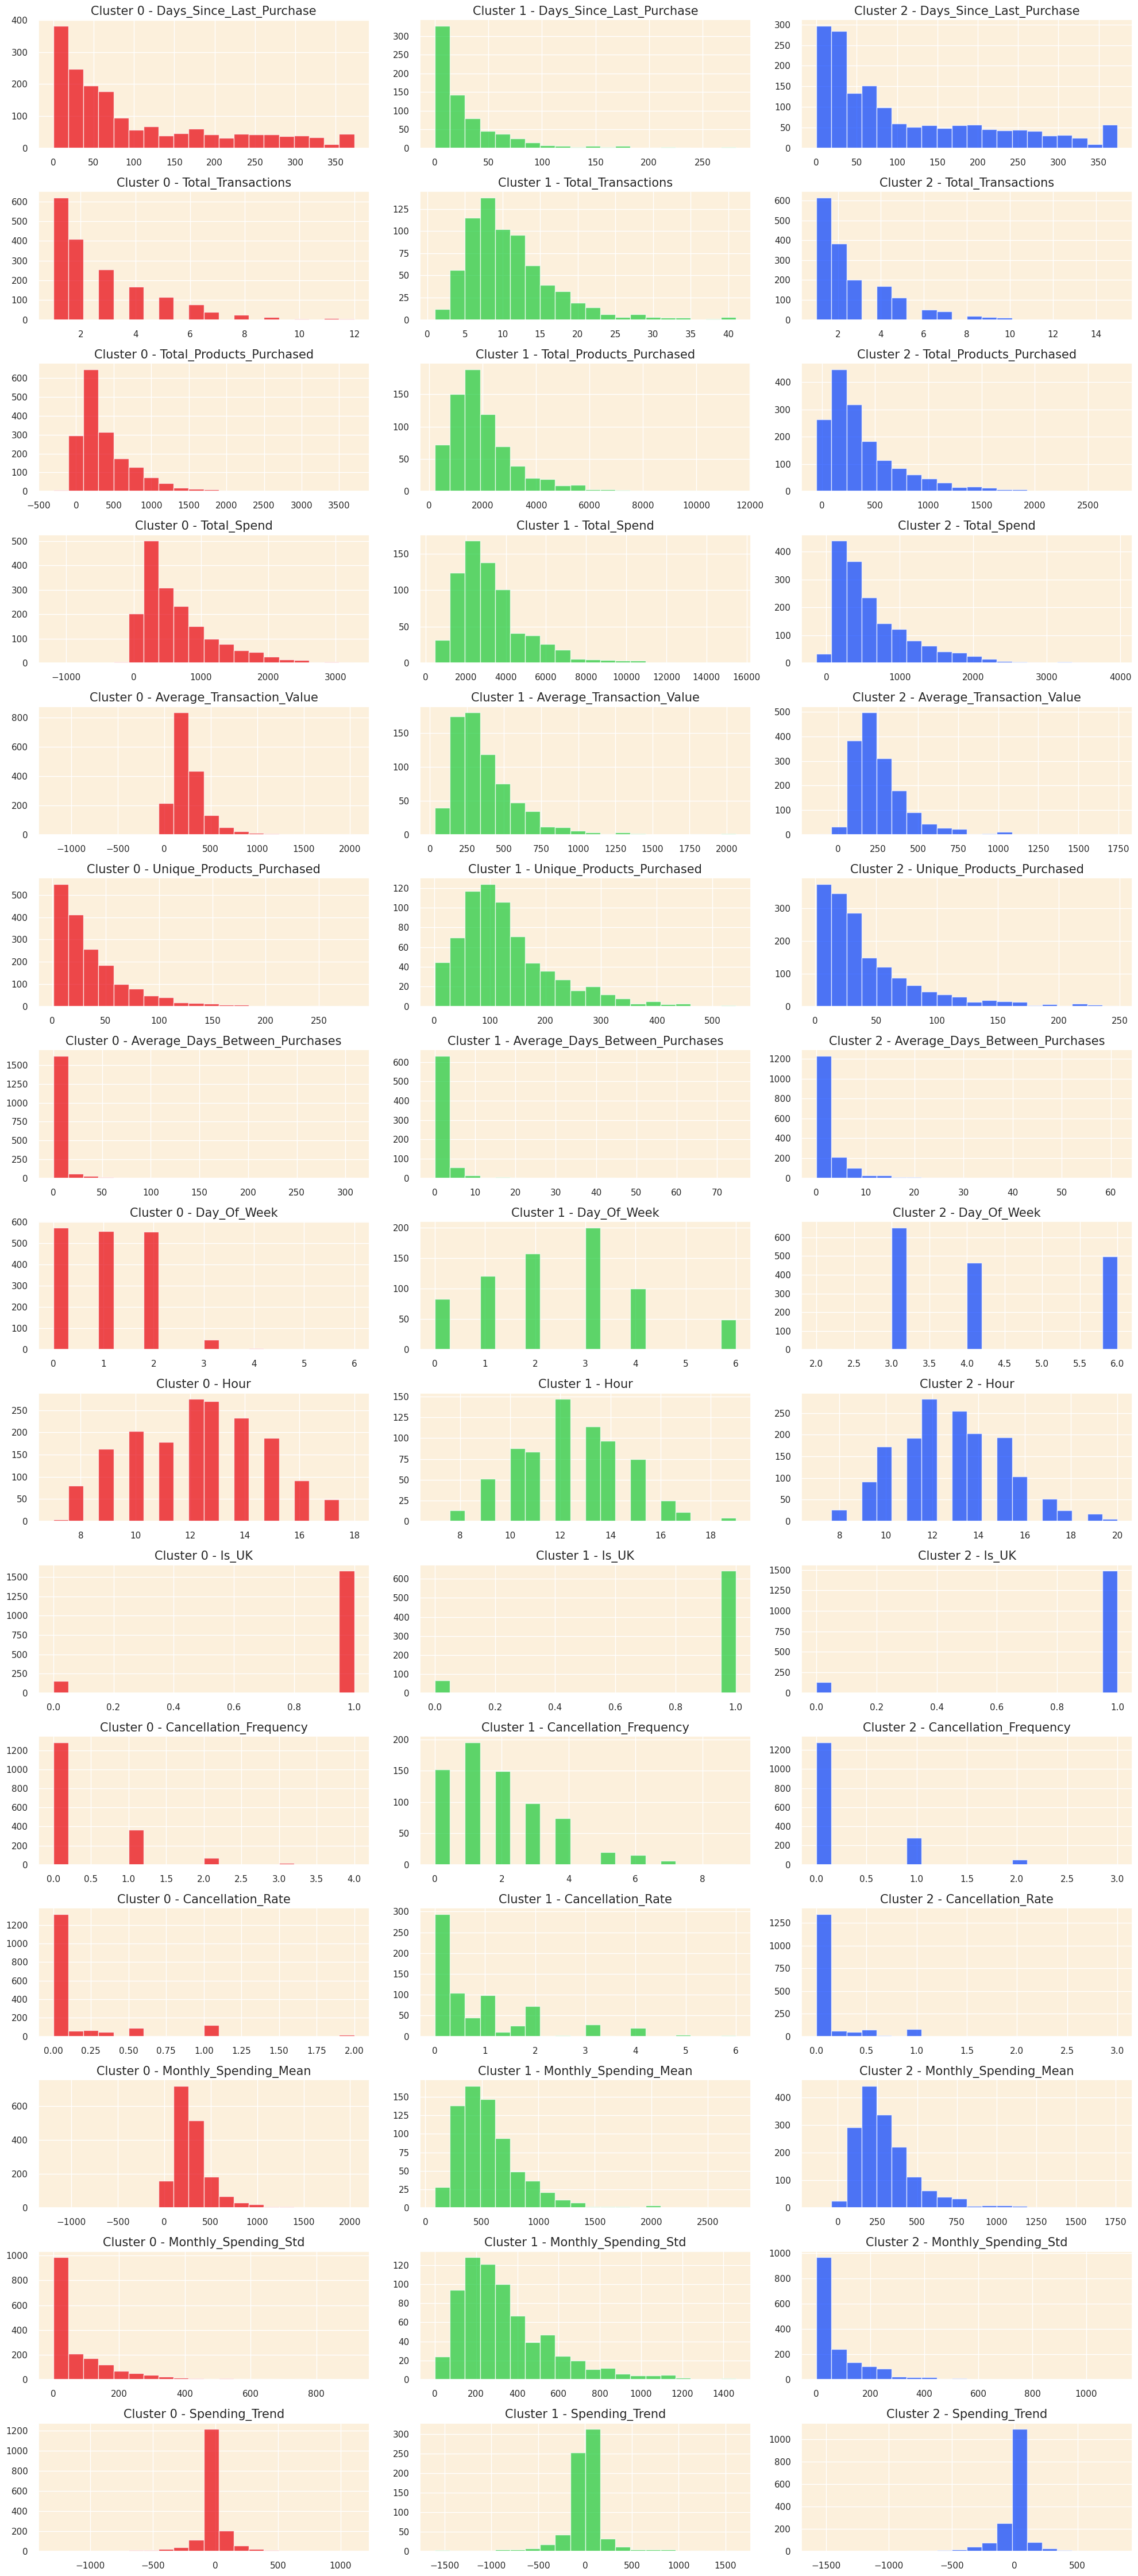

In [ ]:
# построение гистограммы для каждой фичи, сегментируемой по кластерам
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# построение гистограм
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# корректировка макета для предотвращения перекрытия
plt.tight_layout()
plt.show()

# Рекомендательная система

 Анализируя очищенные данные о клиентах, можно точно определить наиболее продаваемые продукты в каждом кластере. Используя эту информацию, можно разработать персонализированные рекомендации, предлагая три наиболее популярных продукта в группе клиентов, которые они еще не приобрели. Это не только облегчает разработку целевых маркетинговых стратегий, но и обогащает личный опыт покупок, потенциально повышая продажи. Для группы клиентов, которые были определены как выбросы, основным подходом может быть рекомендация случайных продуктов в качестве отправной точки для привлечения их внимания.

In [ ]:
# Шаг 1: Извлечем идентификаторы клиентов из выбросов и удалим их транзакции из основного дф
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Шаг 2: Перед объединением убедимся в согласованности типа данных для CustomerID в обоих дф
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Шаг 3: Объединим данные транзакции с данными клиента, чтобы получить информацию о кластере для каждой транзакции
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Шаг 4: Определим 10 самых продаваемых продуктов в каждом кластере на основе общего количества проданных продуктов
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Шаг 5: Создадим запись о продуктах, приобретенных каждым клиентом в каждом кластере
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Шаг 6: Сгененрируем рекомендации для каждого клиента в каждом кластере
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']

    for customer in customers_in_cluster:
        # идентификация продуктов, уже приобретенных клиентом
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) &
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()

        # найдем топ-3 товара в списке лучших, которые клиент еще не приобрел
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)

        # добавим рекомендации к списку
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Шаг 7: Создадим дф из списка рекомендаций и объединим его с исходными данными о клиентах
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [ ]:
# отобразим 10 случайных строк из рекомендаций
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
15754.0,84879,ASSORTED COLOUR BIRD ORNAMENT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85123A,WHITE HANGING HEART T-LIGHT HOLDER
15733.0,84879,ASSORTED COLOUR BIRD ORNAMENT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85123A,WHITE HANGING HEART T-LIGHT HOLDER
14693.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
14661.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
12425.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
14327.0,84879,ASSORTED COLOUR BIRD ORNAMENT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT
16987.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
17425.0,84879,ASSORTED COLOUR BIRD ORNAMENT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85123A,WHITE HANGING HEART T-LIGHT HOLDER
18121.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,15036,ASSORTED COLOURS SILK FAN,85123A,WHITE HANGING HEART T-LIGHT HOLDER
